In [1]:
from astropy.time import Time
import requests
import numpy as np

T0_isot = "2022-10-09T13:17:00"
T0_ijd = Time(T0_isot).mjd - 51544


acslc_r = requests.get(f"https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//integralhk/api/v1.0/genlc/ACS/{T0_ijd}/20000")
import pandas as pd
import io

acslc = pd.read_csv(io.StringIO(acslc_r.text), skiprows=5, names=['t', 'dt', 'c', 'ds'], delim_whitespace=True)
acslc


from matplotlib import pylab as plt

In [2]:
bkg = np.mean(acslc.c[acslc.t<T0_ijd - 1000./24/3600])


def rebin(x, n):
    N = int(len(x)/n)
    return np.array(x[:N*n]).reshape((N, n)).sum(1)


from scipy.optimize import curve_fit

F = lambda x,a,b,c,d: a+b*x+c*x**2+d*x**3
n = 1000
T = (rebin(acslc.t, n)/n - T0_ijd)*24
m = T < -1
m |= T > 3

curve = curve_fit(
    F,
    T[m],
    (rebin(acslc.c, n)/n - bkg)[m]
    )


curve

(array([-1.45827937e+01, -4.29916314e+00,  2.10266238e-01,  2.92586516e-03]),
 array([[ 1.10826164e-01,  2.08051289e-02, -5.47696719e-03,
         -8.94704751e-04],
        [ 2.08051289e-02,  1.56255518e-02, -9.45498371e-04,
         -6.90606191e-04],
        [-5.47696719e-03, -9.45498371e-04,  3.42733153e-04,
          4.07157718e-05],
        [-8.94704751e-04, -6.90606191e-04,  4.07157718e-05,
          3.37193130e-05]]))

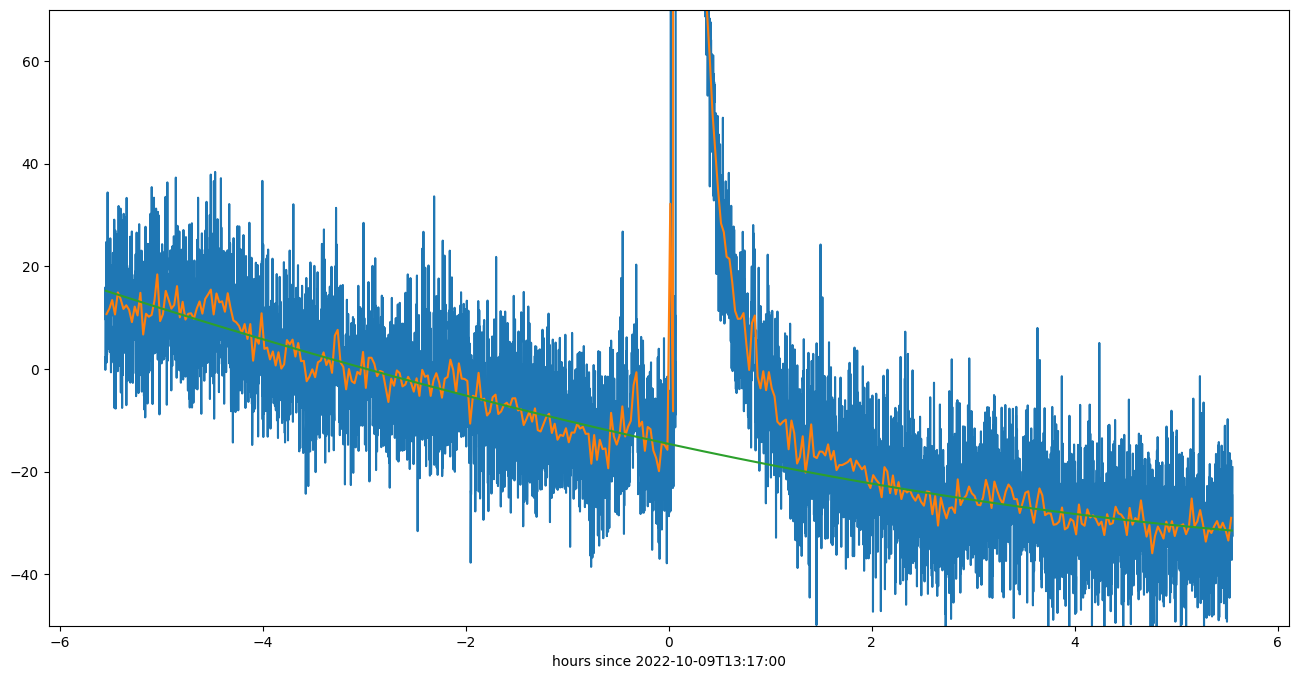

In [4]:
plt.figure(figsize=(16,8))


for n in 100, 2000:

    plt.plot(
        (rebin(acslc.t, n)/n - T0_ijd)*24,
        rebin(acslc.c, n)/n - bkg, # - F((rebin(acslc.t, n)/n - T0_ijd)*24, *curve[0])
    )

# plt.plot(
#     T[m],
#     (rebin(acslc.c, n)/n - bkg)[m]
# )

plt.plot(
    T,
    F(T, *curve[0])
)

plt.ylim([-50,70])

plt.xlabel(f'hours since {T0_isot}')
plt.savefig("acsbkg.pdf")

In [ ]:
acsbkg_pdf = "acsbkg"